In [1]:
from ltlcross_runner import LtlcrossRunner
from IPython.display import display, display_markdown
import pandas as pd
import spot
spot.setup()
import utils

If `rerun` is set to `False` the script uses the precomputed values. If set to `True`, all values are recomputed
(takes more time)

In [2]:
### Tools' setting ###
# PATHS
make_tgba   = 'ltl2tgba --deterministic -f %f' 
owl_version = '18.06'
owl_bin     = 'owl-'+owl_version+'/bin/'
# Tools
owl         = owl_bin+'ltl2ldgba -i %f -n'
nba2ldba    = make_tgba + ' --ba | '+owl_bin+'nba2ldba'
seminator   = make_tgba + ' | ./seminator'
cy          = make_tgba + ' | ./seminator --via-tba'
old         = make_tgba + ' | seminator'
# Optimizations
weak        = ' --powerset-for-weak'
entry       = ' --cut-on-SCC-entry'
levels      = ' --skip-levels'
avoid       = ' --bscc-avoid'
reuse       = ' --reuse-good-SCC'
power       = ' --powerset-on-cut'
simpl_in    = ' --simplify-input'

# Options
cut         = ' --cd'
autfilt     = ' | autfilt'
new_autfilt = ' | ../spot_dev/bin/autfilt'
simp_sd     = ' --small --tgba'
simp_cd     = ' -x simul=1,ba-simul=1 --small --tgba'
nos         = ' -s0' # disables Spot's simplifications used in Seminator
end         = ' > %O' # saves result to file

def cd(tool):
    if tool.startswith('owl'):
        return tool
    return tool + cut

def sd(tool):
    if tool.startswith('owl'):
        return tool + ' -n'
    return tool

def simpl(tool, level, simpl):
    if (not tool.startswith('owl')) and level == 'no':
        tool += nos
    if level == 'no':
        return tool
    if level == 'yes':
        return tool + autfilt + simpl
    return tool + new_autfilt + simpl

d = {
#    'old'          : old,
    'ltl2ldba'     : owl,
#    'entry'        : seminator + entry,
#    'e+simpl'      : seminator + entry + simpl_in,
    'es+weak'      : seminator + entry + simpl_in + weak,
#    'es+power'     : seminator + entry + simpl_in + power,
    'esw+avoid'    : seminator + entry + simpl_in + weak + avoid,
    'esw+reuse'    : seminator + entry + simpl_in + weak + reuse,
    'esw+levels'   : seminator + entry + simpl_in + weak + levels,
    'eswal'        : seminator + entry + simpl_in + weak + avoid + levels,
    'eswrl'        : seminator + entry + simpl_in + weak + reuse + levels,
    'eswpal'       : seminator + entry + simpl_in + weak + avoid + levels + power,
    'eswprl'       : seminator + entry + simpl_in + weak + reuse + levels + power,
    
}

### Ltlcross runner configuration ###
tools = {}
    
for (name, cmd) in d.items():
    for level in ['no','yes','new']:
        tools[f'cd.{name}.{level}'] = simpl(cd(cmd), level, simp_cd) + end
        tools[f'sd.{name}.{level}'] = simpl(sd(cmd), level, simp_sd) + end

sd_tools = [t for t in tools.keys() if t.startswith('sd')]
cd_tools = [t for t in tools.keys() if t.startswith('cd')]
    
### Numbers to measure ###
cols = ['states','edges','transitions','nondet_states','exit_status','time','acc']
tool_order = list(d.keys())

In [3]:
rerun = True

In [4]:
runners = {}
for source in ('literature','random'):
    for t in ['nd']:
        name = '{}_{}'.format(source,t)
        runners[name] = \
            LtlcrossRunner(tools,\
                    res_filename='data/{}.csv'.format(name),\
                    formula_files=['formulae/{}.ltl'.format(name)],\
                    cols=cols)
        if rerun:
            runners[name].run_ltlcross(timeout='120',check=False)
        runners[name].parse_results()

In [5]:
def get_counts(runner):
    v = r.values.states.copy()
    v.columns = pd.MultiIndex.from_tuples([tuple(c.split('.')) for c in v.columns])
    return v.cd.dropna().count()[0], v.sd.dropna().count()[0]

## Cummulative results

Gather the data into one big DataFrame

In [6]:
data = pd.DataFrame()
for (name,r) in runners.items():
    # Divide into sd_tools & cd_tools to treat timeouts separately.
    tmp_cd = pd.DataFrame(r.cummulative(tools=cd_tools),columns=[name])
    tmp_sd = pd.DataFrame(r.cummulative(tools=sd_tools),columns=[name])
    data = data.append(tmp_cd.append(tmp_sd).transpose())
data

tool,cd.ltl2ldba.no,cd.ltl2ldba.yes,cd.ltl2ldba.new,cd.es+weak.no,cd.es+weak.yes,cd.es+weak.new,cd.esw+avoid.no,cd.esw+avoid.yes,cd.esw+avoid.new,cd.esw+reuse.no,...,sd.eswal.new,sd.eswrl.no,sd.eswrl.yes,sd.eswrl.new,sd.eswpal.no,sd.eswpal.yes,sd.eswpal.new,sd.eswprl.no,sd.eswprl.yes,sd.eswprl.new
literature_nd,455,354,354,614,380,380,503,371,371,502,...,310,412,310,310,381,292,292,381,292,292
random_nd,1087,833,833,1900,951,951,1046,797,797,1043,...,705,914,701,701,874,711,711,871,707,707


Get the number of formulas such that all tools finished within timeout for each category.

In [7]:
counts = pd.DataFrame(index=pd.Index([],name='source'),columns=['cd..n','sd..n'])
for (name,r) in runners.items():
    cd_c, sd_c = get_counts(r)
    counts = counts.append(pd.DataFrame({'cd..n':cd_c,'sd..n':sd_c},index=[name]))
counts

,cd..n,sd..n
literature_nd,23,23
random_nd,100,100


Converts the DataFrame to use MultiIndices for rows and columns

In [8]:
from pandas.api.types import CategoricalDtype
automata_type = CategoricalDtype(categories=['det','cd','sd','nd'], ordered=True)
source_type = CategoricalDtype(categories=['random', 'literature', 'rand. (T/O)', 'lit. (T/O)'], ordered=True)

In [9]:
def make_hierarchical(data):
    # Split index into origin & ltl2tgba's output type
    df = data.copy()
    df.index.name = 'origin'
    df.reset_index(inplace=True)
    df['type'] = df.origin.apply(lambda x: x.split('_')[1]).astype(automata_type)
    df['origin'] = df.origin.apply(lambda x: x.split('_')[0]).astype(source_type)
    df = df.set_index(['origin','type']).sort_index()
    # Split columns in tool & reductions
    df.columns = pd.MultiIndex.from_tuples([tuple(c.split('.')) for c in df.columns])
    return df

In [10]:
tmp = make_hierarchical(data.join(counts)).sort_index(axis=1)
tmp

cd                                                           \
                     es+weak            esw+avoid            esw+levels         
                   n     new    no  yes       new    no  yes        new    no   
origin     type                                                                 
random     nd    100     951  1900  951       797  1046  797        922  1869   
literature nd     23     380   614  380       371   503  371        376   611   

                     ...      sd                                            \
                     ...  eswpal eswprl           eswrl           ltl2ldba   
                 yes ...     yes    new   no  yes   new   no  yes      new   
origin     type      ...                                                     
random     nd    922 ...     711    707  871  707   701  914  701      750   
literature nd    376 ...     292    292  381  292   310  412  310      327   

                            
                            
                   no  yes  
origin     type             
random     nd    1087  750  
literature nd     455  327  

[2 rows x 56 columns]

In [11]:
tmp.cd

es+weak            esw+avoid            esw+levels        \
                   n     new    no  yes       new    no  yes        new    no   
origin     type                                                                 
random     nd    100     951  1900  951       797  1046  797        922  1869   
literature nd     23     380   614  380       371   503  371        376   611   

                     ...  eswpal eswprl           eswrl            ltl2ldba  \
                 yes ...     yes    new   no  yes   new    no  yes      new   
origin     type      ...                                                      
random     nd    922 ...     781    777  973  777   765  1016  765      833   
literature nd    376 ...     338    338  468  338   367   499  367      354   

                            
                   no  yes  
origin     type             
random     nd    1087  833  
literature nd     455  354  

[2 rows x 28 columns]

In [12]:
tmp.cd.swaplevel(axis=1).new

,,es+weak,esw+avoid,esw+levels,esw+reuse,eswal,eswpal,eswprl,eswrl,ltl2ldba
origin,type,,,,,,,,,
random,nd,951,797,922,791,769,781,777,765,833
literature,nd,380,371,376,371,367,338,338,367,354


In [13]:
tmp.cd.swaplevel(axis=1).no

,,es+weak,esw+avoid,esw+levels,esw+reuse,eswal,eswpal,eswprl,eswrl,ltl2ldba
origin,type,,,,,,,,,
random,nd,1900,1046,1869,1043,1019,976,973,1016,1087
literature,nd,614,503,611,502,499,468,468,499,455


In [14]:
tmp.sd.swaplevel(axis=1).new

,,es+weak,esw+avoid,esw+levels,esw+reuse,eswal,eswpal,eswprl,eswrl,ltl2ldba
origin,type,,,,,,,,,
random,nd,741,735,711,729,705,711,707,701,750
literature,nd,319,313,316,313,310,292,292,310,327


In [15]:
tmp.sd.swaplevel(axis=1).no

,,es+weak,esw+avoid,esw+levels,esw+reuse,eswal,eswpal,eswprl,eswrl,ltl2ldba
origin,type,,,,,,,,,
random,nd,1069,938,1047,935,917,874,871,914,1087
literature,nd,436,416,433,415,412,381,381,412,455


In [16]:
tmp.cd.eswpal

,,new,no,yes
origin,type,,,
random,nd,781,976,781
literature,nd,338,468,338


In [17]:
tmp.sd.eswpal

,,new,no,yes
origin,type,,,
random,nd,711,874,711
literature,nd,292,381,292


## Timeouts

In [18]:
TO_data = pd.DataFrame()
for (name,r) in runners.items():
    TO_data = TO_data.append(pd.DataFrame(r.compute_timeouts(),columns=[name]).transpose())
TO = make_hierarchical(TO_data).replace(0,pd.NaT).dropna(how='all').fillna(0)
TO

Empty DataFrame
Columns: [(cd, es+weak, new), (cd, es+weak, no), (cd, es+weak, yes), (cd, esw+avoid, new), (cd, esw+avoid, no), (cd, esw+avoid, yes), (cd, esw+levels, new), (cd, esw+levels, no), (cd, esw+levels, yes), (cd, esw+reuse, new), (cd, esw+reuse, no), (cd, esw+reuse, yes), (cd, eswal, new), (cd, eswal, no), (cd, eswal, yes), (cd, eswpal, new), (cd, eswpal, no), (cd, eswpal, yes), (cd, eswprl, new), (cd, eswprl, no), (cd, eswprl, yes), (cd, eswrl, new), (cd, eswrl, no), (cd, eswrl, yes), (cd, ltl2ldba, new), (cd, ltl2ldba, no), (cd, ltl2ldba, yes), (sd, es+weak, new), (sd, es+weak, no), (sd, es+weak, yes), (sd, esw+avoid, new), (sd, esw+avoid, no), (sd, esw+avoid, yes), (sd, esw+levels, new), (sd, esw+levels, no), (sd, esw+levels, yes), (sd, esw+reuse, new), (sd, esw+reuse, no), (sd, esw+reuse, yes), (sd, eswal, new), (sd, eswal, no), (sd, eswal, yes), (sd, eswpal, new), (sd, eswpal, no), (sd, eswpal, yes), (sd, eswprl, new), (sd, eswprl, no), (sd, eswprl, yes), (sd, eswrl, new), (sd, eswrl, no), (sd, eswrl, yes), (sd, ltl2ldba, new), (sd, ltl2ldba, no), (sd, ltl2ldba, yes)]
Index: []

[0 rows x 54 columns]

# Final results
We use the `display` function to propagate the results to notebooks that just run this one.

In [19]:
display_markdown('''### Comparison of tools producing cut-deterministic automata
All tools finished within the one-minute time limit.

#### Without simplifications
''',raw=True)

### Comparison of tools producing cut-deterministic automata
All tools finished within the one-minute time limit.

#### Without simplifications


In [20]:
display(tmp.cd.swaplevel(axis=1).no)

,,es+weak,esw+avoid,esw+levels,esw+reuse,eswal,eswpal,eswprl,eswrl,ltl2ldba
origin,type,,,,,,,,,
random,nd,1900,1046,1869,1043,1019,976,973,1016,1087
literature,nd,614,503,611,502,499,468,468,499,455


In [21]:
display_markdown('#### With simplifications', raw=True)

#### With simplifications

In [22]:
display(tmp.cd.swaplevel(axis=1).yes)

,,es+weak,esw+avoid,esw+levels,esw+reuse,eswal,eswpal,eswprl,eswrl,ltl2ldba
origin,type,,,,,,,,,
random,nd,951,797,922,791,769,781,777,765,833
literature,nd,380,371,376,371,367,338,338,367,354


In [23]:
display_markdown('''### Comparison of tools producing semi-deterministic automata
All tools finished within the one-minute time limit.

#### Without simplifications
''',raw=True)

### Comparison of tools producing semi-deterministic automata
All tools finished within the one-minute time limit.

#### Without simplifications


In [24]:
display(tmp.sd.swaplevel(axis=1).no)

,,es+weak,esw+avoid,esw+levels,esw+reuse,eswal,eswpal,eswprl,eswrl,ltl2ldba
origin,type,,,,,,,,,
random,nd,1069,938,1047,935,917,874,871,914,1087
literature,nd,436,416,433,415,412,381,381,412,455


In [25]:
display_markdown('#### With simplifications', raw=True)

#### With simplifications

In [26]:
display(tmp.sd.swaplevel(axis=1).yes)

,,es+weak,esw+avoid,esw+levels,esw+reuse,eswal,eswpal,eswprl,eswrl,ltl2ldba
origin,type,,,,,,,,,
random,nd,741,735,711,729,705,711,707,701,750
literature,nd,319,313,316,313,310,292,292,310,327


In [27]:
todo = runners['random_nd'].smaller_than('cd.ltl2ldba.new','cd.eswprl.new')
print(todo.size)
todo

36


,tool,cd.eswprl.new,cd.ltl2ldba.new
form_id,formula,,
1,G(Fa U X(b & Fc)),14,6
7,FG(Fa U (Fb R c)),32,4
10,G(a U Xb),3,2
15,GF((a & Gb) R c),6,5
17,GFa | G(Gb | Xa),5,4
19,FG((F((a & G!b) | (!a & Fb)) & (!b | F(b R c))) | (b & G((!b U !c) & ((!a & G!b) | (a & Fb))))),14,6
20,G(a | X(GFa | (a M b))) R !b,10,3
29,X(a U XG(b U (c | X(c M d)))),5,4
48,GF((Ga & F((b & G!c) | (!b & Fc))) | (F!a & G((b & Fc) | (!b & G!c)))),10,9


In [28]:
rr = runners['random_nd']
reuse = "cd.eswprl"
avoid = "cd.eswpal"
diff = rr.smaller_than(f'{avoid}.new',f'{reuse}.new')
print(diff.size)
diff

0


,tool,cd.eswpal.new,cd.eswprl.new
form_id,formula,,


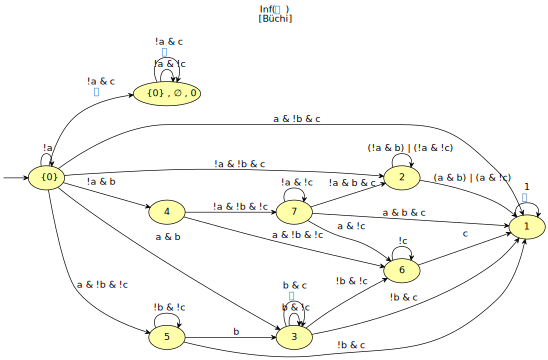

In [29]:
rr.aut_for_id(0,f'{reuse}.no')

In [30]:
list(todo.index.droplevel().values)

['G(Fa U X(b & Fc))',
 'FG(Fa U (Fb R c))',
 'G(a U Xb)',
 'GF((a & Gb) R c)',
 'GFa | G(Gb | Xa)',
 'FG((F((a & G!b) | (!a & Fb)) & (!b | F(b R c))) | (b & G((!b U !c) & ((!a & G!b) | (a & Fb)))))',
 'G(a | X(GFa | (a M b))) R !b',
 'X(a U XG(b U (c | X(c M d))))',
 'GF((Ga & F((b & G!c) | (!b & Fc))) | (F!a & G((b & Fc) | (!b & G!c))))',
 'GF((a & F(!b | Xc)) | (!a & G(b & X!c)))',
 'XG(a | Fc | Xb)',
 'FG(a | XF(a & XFb))',
 'FG((a & (!b | c | XFb | Gd)) | (!a & b & !c & XG!b & F!d))',
 'XG(a & F((!b & F!c) | (b & Gc)))',
 'F(((Fa R (b | c)) & ((c U b) R d)) | ((G!a U (!b & !c)) & ((!c R !b) U !d))) R d',
 'X(a & GF(b & X(b W c)))',
 'GF((a & X(b & (FGc U Xc))) | ((!a | X!b) & X(GF!c R X!c)))',
 'FG(F!a & (b U Xa))']